# DC Resistivity Survey

In this notebook, we set up a 4 electrode DC resistivity experiment using [SimPEG](https://simpeg.xyz). This notebooks will run both a surface and a cross borehole survey. 

In [1]:
# scientific python
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib import rcParams
import os
from scipy import sparse as sp

# SimPEG - specific
import discretize
from SimPEG import DC as dc
from SimPEG import Maps as maps
from SimPEG import Directives as directives
from SimPEG import Regularization as regularization
from SimPEG import Optimization as optimization
from SimPEG import DataMisfit as data_misfit
from SimPEG import InvProblem as inverse_problem
from SimPEG import Inversion as inversion
from pymatsolver import Pardiso

In [2]:
rcParams["font.size"] = 14

In [3]:
fig_directory = os.path.sep.join(["..", "figures", ""])
dpi = 200  # increase for higher quality figures

print("saving figures to {}".format(fig_directory))

saving figures to ../figures/


## Survey Type

"surface" or "borehole" survey

In [4]:
survey_type = "borehole"  # or "surface"

# create a mesh

Here, we create a 2D mesh. The core region of the mesh has cells that are `cs` wide. 

In [5]:
cs = 1  # core cell size
npad = 8  # number of padding cells
padding_factor = 1.5  # expansion factor for padding cells

core_x = 80  # horizontal extent of the core region
core_y = 35  # vertical extent of the core region

# define the mesh
hx = [(cs, npad, -padding_factor), (cs, int(core_x/cs)), (cs, npad, padding_factor)]
hy = [(cs, npad, -padding_factor), (cs, int(core_y/cs))]
mesh = discretize.TensorMesh([hx, hy], "CN")
print("The mesh has {} cells".format(mesh.nC))

The mesh has 4128 cells


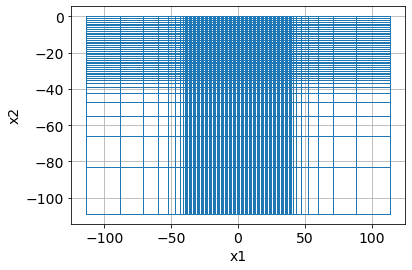

In [6]:
mesh.plotGrid()

# set up the forward simulation

For this first simulation, we will put receivers at all cell centers so we can plot out the potentials, currents and electric field on the mesh

## survey parameters

Degine the receivers and source

In [7]:
# put receivers at all cell centers to look at potentials everywhere
rx = dc.Rx.Pole_ky(mesh.gridCC)

# source location
if survey_type == "surface":
    a_location = np.r_[-30 - cs/2., 0.]
    b_location = np.r_[30 + cs/2., 0.]
elif survey_type == "borehole": 
    a_location = np.r_[-15 - cs/2., -5-cs/2.]
    b_location = np.r_[15 + cs/2., -30-cs/2.] 
    
src = dc.Src.Dipole([rx], a_location, b_location)

In [8]:
survey = dc.Survey_ky([src])
simulation = dc.Problem2D_CC(mesh, sigmaMap=maps.IdentityMap(mesh), Solver=Pardiso)

simulation.pair(survey)

# create a model

Define a conductivity model (S/m)

In [9]:
sigma_halfspace = 1e-2
model = sigma_halfspace * np.ones(mesh.nC)

# run the forward simulation

In [10]:
%%time
potentials = survey.dpred(model)

CPU times: user 1.87 s, sys: 75.3 ms, total: 1.94 s
Wall time: 822 ms


In [11]:
# compute electric field and currents 
mesh.setCellGradBC("neumann")
cellGrad = mesh.cellGrad
faceDiv = mesh.faceDiv

electric_field = -cellGrad * potentials
current_density = simulation.MfRhoI * simulation.Grad * potentials

# plot potentials and currents

In [12]:
xlim = np.r_[-40, 40]
ylim = np.r_[-40, 8]

In [13]:
def add_source_electrodes(ax, markersize=8):
    """
    Function to add the source locations to a plot
    """
    ax.plot(
        a_location[0], a_location[1], 
        marker="v" if survey_type == "surface" else "s", 
        color="red", markersize=markersize, markeredgecolor="k"
    )
    ax.plot(
        b_location[0], b_location[1], 
        marker="v" if survey_type == "surface" else "s", 
        color="blue", markersize=markersize, markeredgecolor="k"
    )
    
    if survey_type == "surface":
        xytextA1 = a_location + np.r_[0., 2.5]
        xytextB1 = b_location + np.r_[0., 2.5]
    else: 
        xytextA1 = a_location + np.r_[-2.5, 0.]
        xytextB1 = b_location + np.r_[ 2.5, 0.]
    
    ax.annotate("A", xy=xytextA1, xytext=xytextA1, ha="center")
    ax.annotate("B", xy=xytextB1, xytext=xytextB1, ha="center")

### Potentials

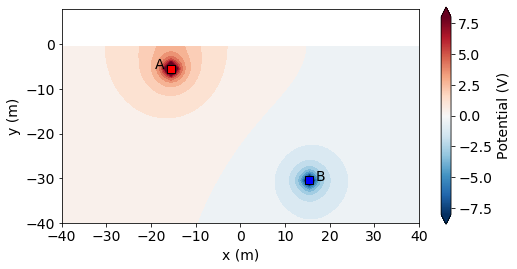

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

clim = 0.25*potentials.max()*np.r_[-1, 1]
colormap = "RdBu_r"

norm = colors.Normalize(vmin=clim.min(), vmax=clim.max())
out = ax.contourf(
    mesh.gridCC[:, 0].reshape(mesh.vnC, order="F"), 
    mesh.gridCC[:, 1].reshape(mesh.vnC, order="F"), 
    potentials.reshape(mesh.vnC, order="F"), 
    100, 
    norm=norm, 
    cmap=colormap,
    vmin=clim.min(),
    vmax=clim.max(),
    extend="both"
)
add_source_electrodes(ax)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap),  ax=ax, extend="both")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)


ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
cbar.set_label("Potential (V)")

filename = "{}_DC_potentials".format(survey_type)
plt.savefig("{}{}".format(fig_directory, filename), bbox_inches="tight", dpi=dpi)

//miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


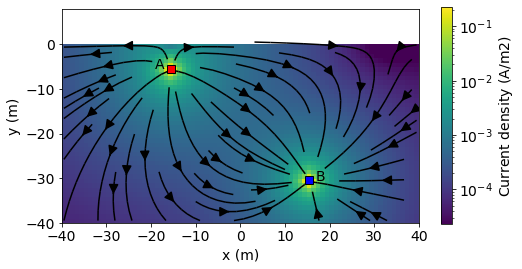

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

clim = np.abs(current_density).max()*np.r_[1e-4, 1e0]
norm = colors.LogNorm(vmin=clim.min(), vmax=clim.max())

out = mesh.plotImage(
    mesh.aveF2CCV * current_density,
    view="vec",
    vType="CCv",
    ax=ax, 
    range_x=xlim, 
    range_y=ylim, 
    clim=clim,
    pcolorOpts={"norm": norm},
    streamOpts={"color":"k", "arrowsize": 2, "density": 0.75}
)

cbar = plt.colorbar(out[0], ax=ax)

add_source_electrodes(ax)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
cbar.set_label("Current density (A/m$2$)")

filename = "{}_DC_currents".format(survey_type)
plt.savefig("{}{}".format(fig_directory, filename), bbox_inches="tight", dpi=dpi)

# plot sensitivities

Here, we compute the sensitivities and model resolution matrix. The inversion model is log conductivity (so we pass an `maps.ExpMap` to the forward simulation in order to convert from log conductivity to electrical conductivity) 

There is a single dipole receiver for the survey

In [16]:
if survey_type == "surface":
    m_location = np.r_[-10 - cs/2., 0.]
    n_location = np.r_[10 + cs/2., 0.]
elif survey_type == "borehole":
    m_location = np.r_[a_location[0], b_location[1]]
    n_location = np.r_[b_location[0], a_location[1]]

rx2 = dc.Rx.Dipole_ky(m_location, n_location)
src2 = dc.Src.Dipole([rx2], a_location, b_location)

In [17]:
survey2 = dc.Survey_ky([src2])
simulation2 = dc.Problem2D_CC(mesh, sigmaMap=maps.ExpMap(mesh), Solver=Pardiso)

simulation2.pair(survey2)

In [18]:
%%time
fields = simulation2.fields(np.log(model))
J = simulation2.Jtvec(np.log(model), np.array([1.]), f=fields)

CPU times: user 2.19 s, sys: 102 ms, total: 2.29 s
Wall time: 715 ms


In [19]:
def add_potential_electrodes(ax, markersize=8):
    """
    Function to add the receiver locations to a plot. 
    """
    ax.plot(
        m_location[0], m_location[1], 
        marker="v" if survey_type == "surface" else "s", 
        color="yellow", markersize=markersize, markeredgecolor="k"
    )
    ax.plot(
        n_location[0], n_location[1], 
        marker="v" if survey_type == "surface" else "s", 
        color="green", markersize=markersize, markeredgecolor="k")
    
    if survey_type == "surface": 
        xytextM1 = m_location + np.r_[0, 2.5]
        xytextN1 = n_location + np.r_[0, 2.5]
    elif survey_type == "borehole":
        xytextM1 = m_location + np.r_[-2.5, 0.]
        xytextN1 = n_location + np.r_[2.5, 0.]
    
    ax.annotate("M", xy=xytextM1, xytext=xytextM1, ha="center")
    ax.annotate("N", xy=xytextN1, xytext=xytextN1, ha="center")

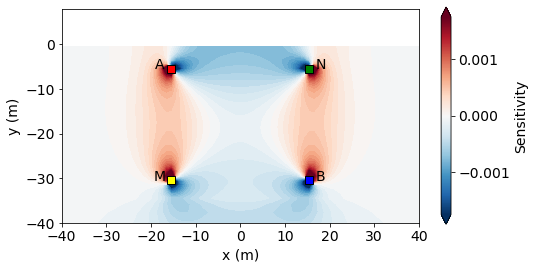

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

clim = 0.5*J.max()*np.r_[-1, 1]
colormap = "RdBu_r"

norm = colors.Normalize(vmin=clim.min(), vmax=clim.max())
out = ax.contourf(
    mesh.gridCC[:, 0].reshape(mesh.vnC, order="F"), 
    mesh.gridCC[:, 1].reshape(mesh.vnC, order="F"), 
    J.reshape(mesh.vnC, order="F"), 
    100, 
    norm=norm, 
    cmap=colormap,
    vmin=clim.min(),
    vmax=clim.max(),
    extend="both"
)
add_source_electrodes(ax)
add_potential_electrodes(ax)

cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap),  ax=ax, extend="both")

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)


ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
cbar.set_label("Sensitivity")

filename = "{}_DC_sensitivity".format(survey_type)
plt.savefig("{}{}".format(fig_directory, filename), bbox_inches="tight", dpi=dpi)

## model resolution matrix

To compute the model resolution matrix, we set up an inverse problem. We estimate a `beta` value by comparing the value of the data misfit and the model objective function when given a random vector.

### set up an inverse problem

In [21]:
m0 = np.log(model)  # we are running the analysis wrt the log-coductivity 
survey2.makeSyntheticData(np.log(model), f=fields)

SimPEG.Survey assigned default std of 5%


array([0.22595541])

In [22]:
reg = regularization.Tikhonov(mesh, alpha_s=1e-2, alpha_x=1., mref=m0)
dmis = data_misfit.l2_DataMisfit(survey2)
beta = directives.BetaEstimate_ByEig()
opt = optimization.GaussNewton()
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [23]:
inv = inversion.BaseInversion(inv_prob, directiveList=[beta])

inv_prob.startup(m0)
inv.directiveList.call('initialize')

print(inv_prob.beta)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
3.9349149832984125


In [24]:
phi, g, H = inv_prob.evalFunction(m0)

### the following is an expensive / slow cell

This is a bit hacky (going from dense to sparse matrices, etc is quite inefficient) - we should get it plugged into SimPEG more cleanly down the line

What I am doing in the following cells is computing the Hessian of the data misfit term (first cell), and in the cell afer that, I compute it for the regularization (much cheaper)

In [25]:
%%time

H_dmis = np.zeros((mesh.nC, mesh.nC))
for i in range(mesh.nC):
    if np.mod(i, 100) == 0:
        print("{} of {}".format(i, mesh.nC))
    v = np.zeros(mesh.nC)
    v[i] = 1
    H_dmis[:, i] = dmis.deriv2(m0, v=v, f=fields)

0 of 4128
100 of 4128
200 of 4128
300 of 4128
400 of 4128
500 of 4128
600 of 4128
700 of 4128
800 of 4128
900 of 4128
1000 of 4128
1100 of 4128
1200 of 4128
1300 of 4128
1400 of 4128
1500 of 4128
1600 of 4128
1700 of 4128
1800 of 4128
1900 of 4128
2000 of 4128
2100 of 4128
2200 of 4128
2300 of 4128
2400 of 4128
2500 of 4128
2600 of 4128
2700 of 4128
2800 of 4128
2900 of 4128
3000 of 4128
3100 of 4128
3200 of 4128
3300 of 4128
3400 of 4128
3500 of 4128
3600 of 4128
3700 of 4128
3800 of 4128
3900 of 4128
4000 of 4128
4100 of 4128
CPU times: user 25min 23s, sys: 36.1 s, total: 25min 59s
Wall time: 6min 35s


In [26]:
H_reg = np.zeros((mesh.nC, mesh.nC))
for i in range(mesh.nC):
    v = np.zeros(mesh.nC)
    v[i] = 1
    H_reg[:, i] = reg.deriv2(m0, v)

Compute the model resolution matrix

In [27]:
H = sp.csr_matrix(H_dmis + inv_prob.beta * H_reg)
Hinv = Pardiso(H)

In [28]:
mrm = Hinv * H_dmis

In [29]:
mrm_sum = mrm.sum(1)

### plot the row sum of the model resolution matrix

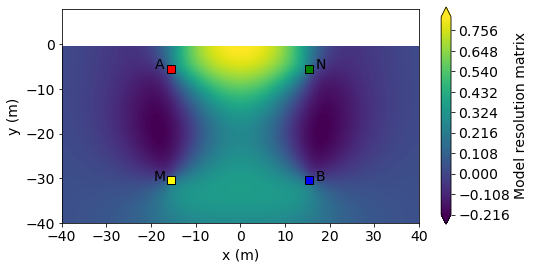

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

norm = colors.Normalize(vmin=clim.min(), vmax=clim.max())
out = ax.contourf(
    mesh.gridCC[:, 0].reshape(mesh.vnC, order="F"), 
    mesh.gridCC[:, 1].reshape(mesh.vnC, order="F"), 
    mrm_sum.reshape(mesh.vnC, order="F"), 
    200, 
    extend="both"
)
add_source_electrodes(ax)
add_potential_electrodes(ax)

cbar = plt.colorbar(out,  ax=ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)


ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
cbar.set_label("Model resolution matrix")

filename = "{}_DC_model_resolution".format(survey_type)
plt.savefig("{}{}".format(fig_directory, filename), bbox_inches="tight", dpi=dpi)